In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Diffusity

┌ Info: Precompiling Diffusity [fca15081-c8d4-4aca-bcfd-1103cbe75c6b]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

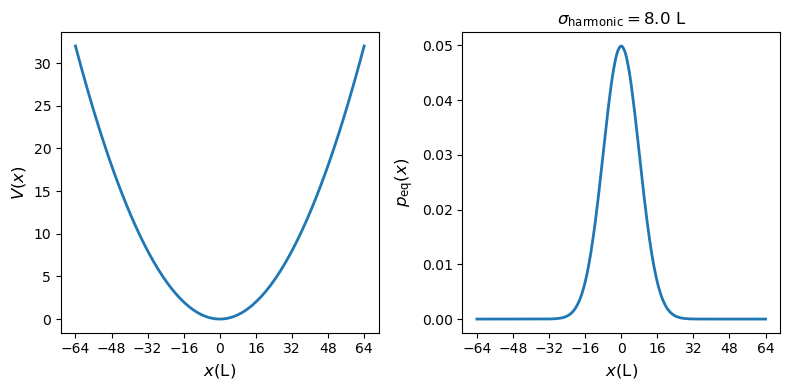

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [4]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [5]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

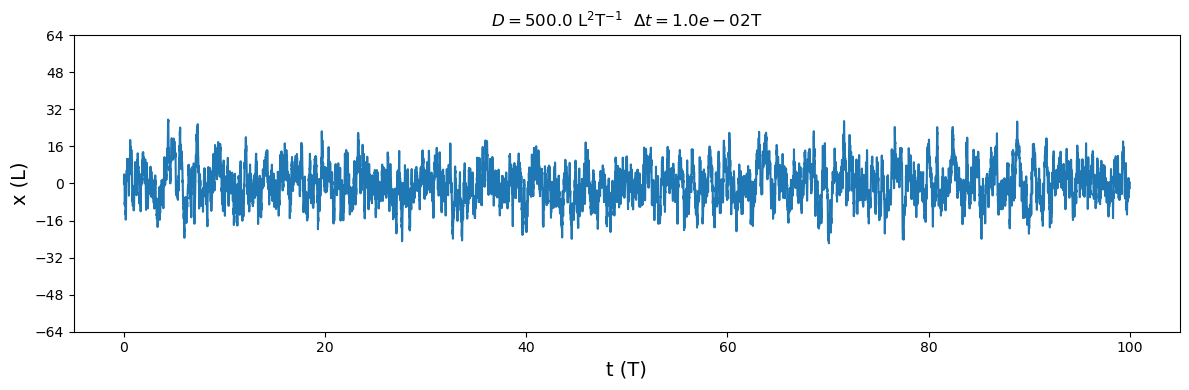

In [9]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: FEM to get eigenvector and eigenvalues when $D=1$

In [6]:
D_unity = 1e0
eigenvalues_prime, eigenvect_mat_prime, rho_eq_by_fem_prime = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_unity, Nv)
weight_Qx_prime = get_weight_Qx(N, Nv, w0, eigenvect_mat_prime);

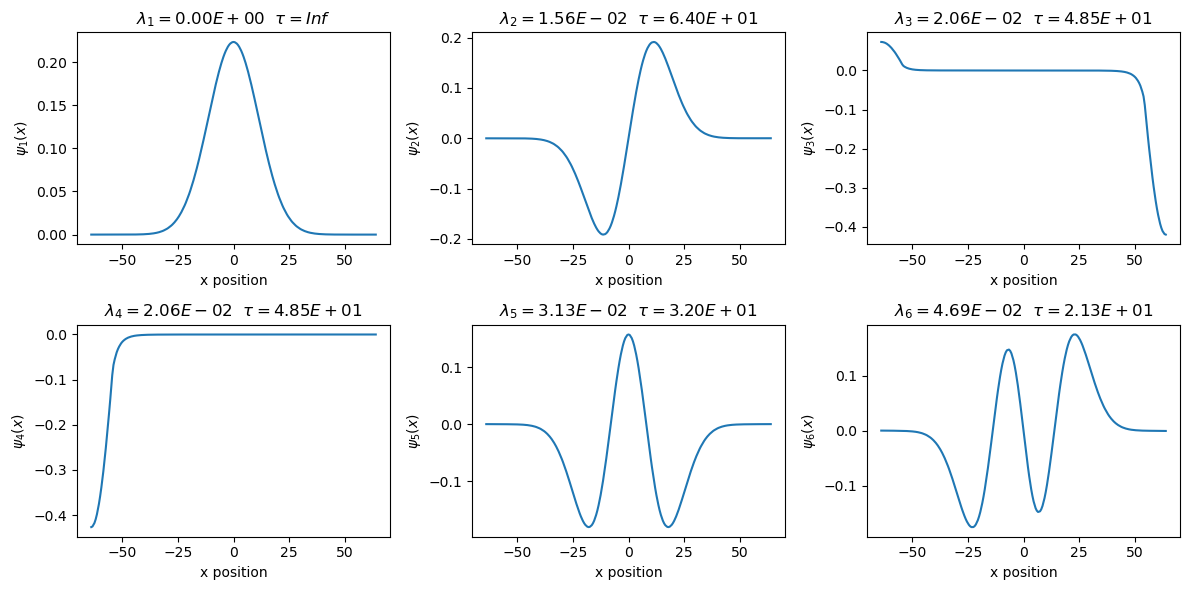

In [46]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

idx_eigvector = 1
for row_id = 1:2
    for col_id = 1:3
        plot_x_Qx_lambda(axes[row_id, col_id], idx_eigvector, eigenvalues, eigenvect_mat, xref)
        idx_eigvector += 1
        #axes[row_id, col_id].set_ylim(-0.4, 0.4)
    end
end

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()

### Part 5: Set Photon $\sigma$

In [7]:
σ_delta = 2.0
k_delta = get_k_by_sigma(σ_delta);

### Part 6: Set $D_{\text{guess}}$

In [8]:
D_guess = 500;

### Part 7: Forward Backward

In [9]:
alpha_mat, beta_mat, Anorm_vec, r_sqrt_array = Diffusity.forward_backward_v0(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, 
    xref, e_norm, interpo_xs, Np, k_delta, D_guess, eigenvalues_prime, save_freq);

### Part 8: Check $\sum \hat{\alpha}(\textbf{s}_n) =1$

In [50]:
store_array = zeros(tau)
for time_idx = 1:tau
    store_array[time_idx] = sum(alpha_mat[:,time_idx] .^ 2)
end

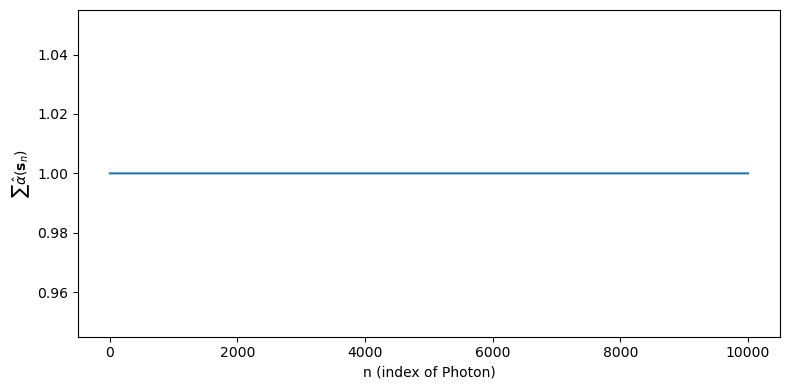

In [54]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

xarray = 1:tau
ax.plot(xarray, store_array)
ax.set_ylabel("\$\\sum \\hat{\\alpha}(\\mathbf{s}_n)\$")
ax.set_xlabel("n (index of Photon)")

plt.tight_layout()
plt.show()

### Part 9: $\gamma(\textbf{x}_n)$ and $\gamma(\textbf{s}_n)$

In [13]:
store_array = zeros(tau)
for time_idx = 1:tau
    gamma_x, gamma_s = Diffusity.get_gamma(N, Nv, w0, alpha_mat, beta_mat, time_idx, eigenvect_mat_prime)
    store_array[time_idx] = sum(gamma_x .* w0)
end

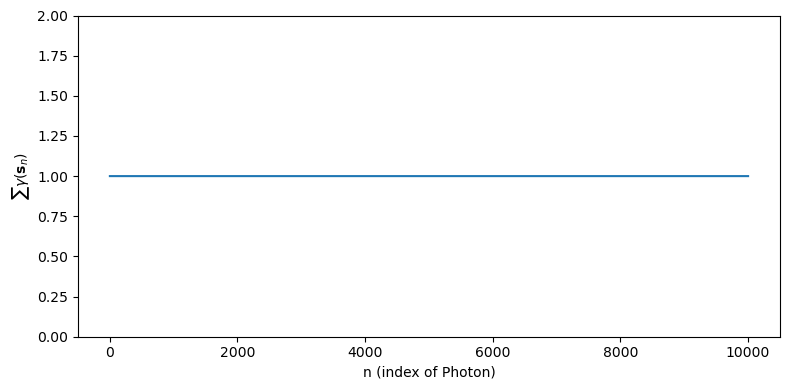

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

xarray = 1:tau
ax.plot(xarray, store_array)
ax.set_ylabel("\$\\sum \\gamma(\\mathbf{s}_n)\$")
ax.set_xlabel("n (index of Photon)")
ax.set_ylim(0,2)

plt.tight_layout()
plt.show()

In [10]:
# Selete time index
time_idx_sele = 4;

In [11]:
gamma_x, gamma_s = Diffusity.get_gamma(N, Nv, w0, alpha_mat, beta_mat, time_idx_sele, eigenvect_mat_prime);

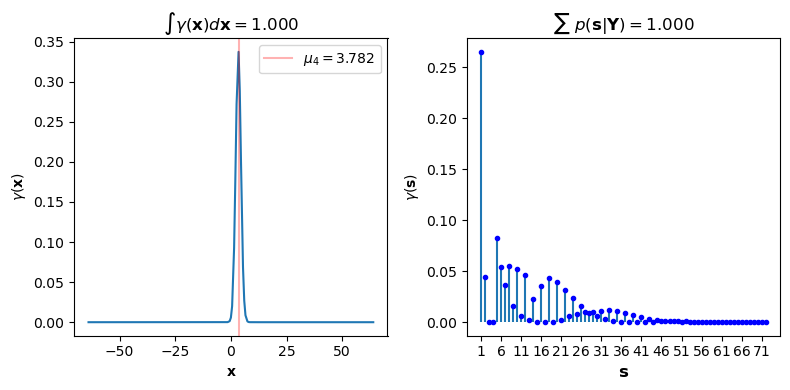

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, gamma_x)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx_sele y_record[time_idx_sele]
ax.axvline(y_record[time_idx_sele], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$\\gamma(\\mathbf{x})\$")
ax.set_xlabel("\$\\mathbf{x}\$")
title = @sprintf "\$ \\int \\gamma(\\mathbf{x}) d\\mathbf{x}=%.3f \$" sum(gamma_x .* w0)
ax.set_title(title)
ax.legend()

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, gamma_s, "b.")
ax.vlines(xarray, ymin=0, ymax=gamma_s)
ax.set_xlabel("\$\\mathbf{s}\$", fontsize=12)
ax.set_ylabel("\$\\gamma(\\mathbf{s})\$")
ax.set_xticks(xticks)
title = @sprintf "\$\\sum~p(\\mathbf{s}|\\mathbf{Y})=%.3f \$" sum(gamma_s)
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/beta4_example.pdf")
plt.show()

### Part 10-1:   $\left(\left<\hat{\alpha}_4| x \right>\right)^2 \left(\left<\hat{\alpha}_4|e^{-\textbf{H}\Delta t} | x \right>\right)^2 = p(\textbf{x}_4, \textbf{x}_5 | \textbf{y}_1,...,\textbf{y}_4)$

In [12]:
expLQDT = exp.(-(D_guess * eigenvalues_prime) .* save_freq);
alpha_hat_4 = alpha_mat[:,4]
alpha_hat_4_edt = expLQDT .* alpha_hat_4
alpha_hat_4_edt[1] = sign(alpha_hat_4_edt[1]) * sqrt(1 - sum((alpha_hat_4_edt[2:end]).^2));

In [13]:
alpha_hat_4_x_square = proj_vector_from_eigenspace_to_xspace(eigenvect_mat_prime, alpha_hat_4) .^ 2
alpha_hat_4_edt_x_square = proj_vector_from_eigenspace_to_xspace(eigenvect_mat_prime, alpha_hat_4_edt) .^ 2;

### Part 10-2: Check the condition of normalization

In [24]:
col_vec = zeros(N,1)
row_vec = zeros(1,N)
col_vec[:,1] = alpha_hat_4_x_square
row_vec[1,:] = alpha_hat_4_edt_x_square
p_x4_x5_mat = col_vec * row_vec;

$\int p(x_4,x_5|y_1,...,y_4) d x_5 = p(x_4|y_1,...,y_4)$

In [25]:
p_x4_marginal_vec = zeros(N,1)
for idx = 1:N
    p_x4_marginal_vec[idx] = sum(w0 .* p_x4_x5_mat[idx,:]) # \int_x5 p(x4,x5) dx5 = p(x4)
end

$\int p(x_4|y_1,...,y_4) d x_4= 1$

In [26]:
sum(w0 .* p_x4_marginal_vec)

0.9999777505350237

### Part 10-3: Draw Heatmap of $p(x_4,x_5|y_1,...,y_4)$

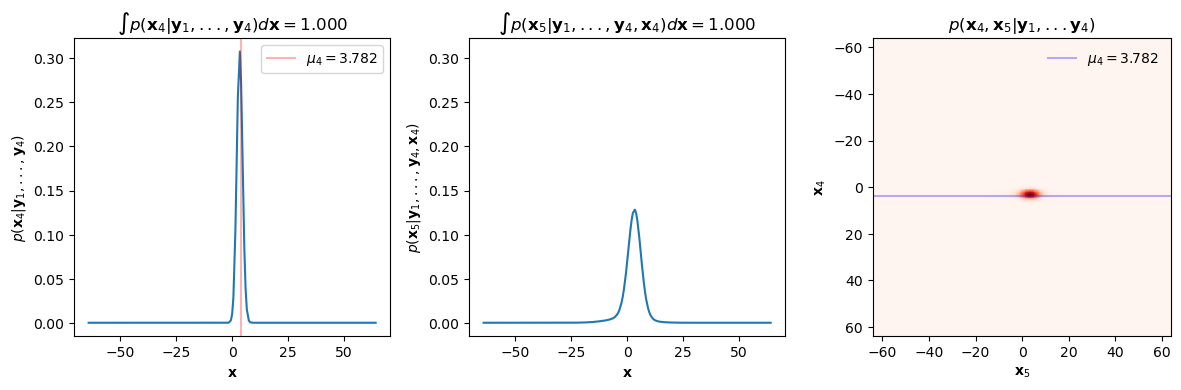

In [95]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, alpha_hat_4_x_square)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" 4 y_record[4]
ax.axvline(y_record[4], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$p(\\mathbf{x}_4|\\mathbf{y}_1,...,\\mathbf{y}_4)\$")
ax.set_xlabel("\$\\mathbf{x}\$")
title = @sprintf "\$ \\int p(\\mathbf{x}_4|\\mathbf{y}_1,...,\\mathbf{y}_4) d\\mathbf{x}=%.3f \$" sum(alpha_hat_4_x_square .* w0)
ax.set_title(title)
ax.legend()
ylims = ax.get_ylim()

ax = axes[2]
ax.plot(xref, alpha_hat_4_edt_x_square)
ax.set_ylabel("\$p(\\mathbf{x}_5|\\mathbf{y}_1,...,\\mathbf{y}_4,\\mathbf{x}_4)\$")
ax.set_xlabel("\$\\mathbf{x}\$")
title = @sprintf "\$ \\int p(\\mathbf{x}_5|\\mathbf{y}_1,...,\\mathbf{y}_4,\\mathbf{x}_4) d\\mathbf{x}=%.3f \$" sum(alpha_hat_4_edt_x_square .* w0)
ax.set_title(title)
ax.set_ylim(ylims)

ax = axes[3]
im = ax.imshow(p_x4_x5_mat, cmap="Reds", extent=(-64,64,64,-64))
ax.set_xlabel("\$\\mathbf{x}_5\$")
ax.set_ylabel("\$\\mathbf{x}_4\$")
title = "\$p(\\mathbf{x}_4, \\mathbf{x}_5| \\mathbf{y}_1,...\\mathbf{y}_4)\$"
ax.set_title(title)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" 4 y_record[4]
ax.axhline(y_record[4], color="blue", label=label, alpha=0.3)
ax.legend(frameon=false)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/p_x4_x5_given_y1toy4.pdf")
plt.show()

### Part 10-4: Draw Heatmap of $p(s_4,s_5|y_1,...,y_4)$

In [77]:
col_vec = zeros(Nv,1)
row_vec = zeros(1,Nv)
col_vec[:,1] = alpha_hat_4 .^ 2
row_vec[1,:] = alpha_hat_4_edt .^ 2
p_s4_s5_mat = col_vec * row_vec;
sum(p_s4_s5_mat)

0.9999999999999999

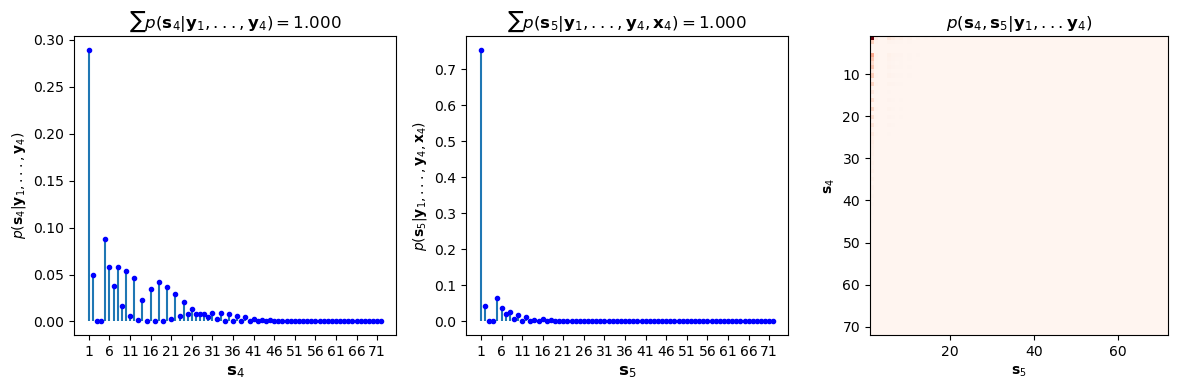

In [96]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, col_vec, "b.")
ax.vlines(xarray, ymin=0, ymax=col_vec)
ax.set_xlabel("\$\\mathbf{s}_4\$", fontsize=12)
ax.set_ylabel("\$p(\\mathbf{s}_4|\\mathbf{y}_1,...,\\mathbf{y}_4)\$")
ax.set_xticks(xticks)
title = @sprintf "\$\\sum p(\\mathbf{s}_4|\\mathbf{y}_1,...,\\mathbf{y}_4) =%.3f \$" sum(col_vec)
ax.set_title(title)

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, row_vec[1,:], "b.")
ax.vlines(xarray, ymin=0, ymax=row_vec[1,:])
ax.set_xlabel("\$\\mathbf{s}_5\$", fontsize=12)
ax.set_ylabel("\$p(\\mathbf{s}_5|\\mathbf{y}_1,...,\\mathbf{y}_4,\\mathbf{x}_4)\$")
ax.set_xticks(xticks)
title = @sprintf "\$ \\sum p(\\mathbf{s}_5|\\mathbf{y}_1,...,\\mathbf{y}_4,\\mathbf{x}_4) =%.3f \$" sum(row_vec)
ax.set_title(title)

ax = axes[3]
im = ax.imshow(p_s4_s5_mat, cmap="Reds", extent=(1,Nv,Nv,1))
ax.set_xlabel("\$\\mathbf{s}_5\$")
ax.set_ylabel("\$\\mathbf{s}_4\$")
title = "\$p(\\mathbf{s}_4, \\mathbf{s}_5| \\mathbf{y}_1,...\\mathbf{y}_4)\$"
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/p_s4_s5_given_y1toy4.pdf")
plt.show()

### Part 11-1:  $\left( \left< x| \hat{\beta}_5 \right> \right)^2$, $\left( \left< x| \textbf{y}_5 | \hat{\beta}_5 \right> \right)^2$, $\left( \frac{\left< x| \textbf{y}_5 | \hat{\beta}_5 \right>}{ || \textbf{y}_5 \left| \hat{\beta}_5 \right>||} \right)^2$

In [180]:
photon_mat = get_photon_matrix_gaussian(y_record[5], xref, e_norm, interpo_xs, Np, w0, k_delta)
psi_photon_psi = eigenvect_mat_prime' * photon_mat * eigenvect_mat_prime;

In [181]:
beta_hat_5 = beta_mat[:,5]
y_beta_hat_5 = psi_photon_psi * beta_hat_5

beta_hat_5_x_square = proj_vector_from_eigenspace_to_xspace(eigenvect_mat_prime, beta_hat_5) .^ 2
y_beta_hat_5_x_square = proj_vector_from_eigenspace_to_xspace(eigenvect_mat_prime, y_beta_hat_5) .^ 2
norm_factor = sum(w0 .* y_beta_hat_5_x_square)
y_beta_hat_5_after_norm_x_square = y_beta_hat_5_x_square ./ norm_factor

y_beta_hat_5_after_norm = y_beta_hat_5 ./ sqrt(norm_factor);

In [182]:
beta_hat_5_square = beta_hat_5 .^ 2
y_beta_hat_5_square = y_beta_hat_5 .^ 2
y_beta_hat_5_after_norm_square = y_beta_hat_5_after_norm .^ 2;

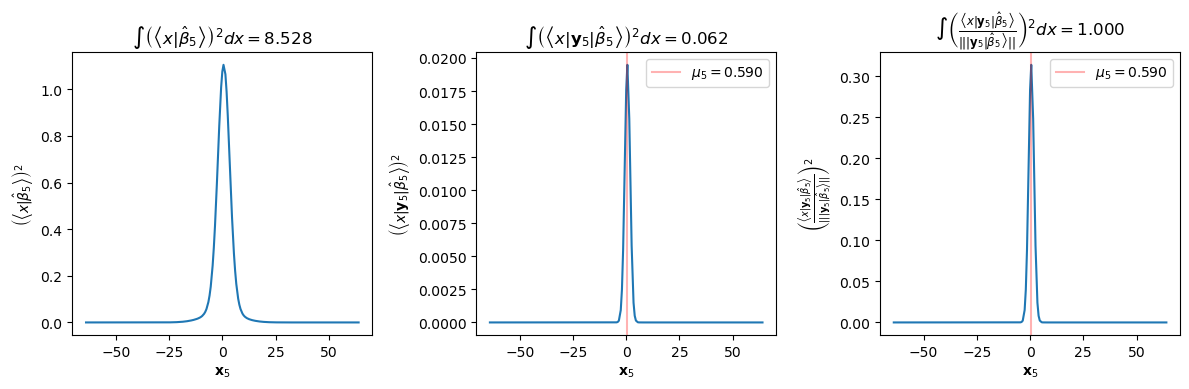

In [132]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, beta_hat_5_x_square)
ax.set_ylabel("\$\\left( \\left< x| \\hat{\\beta}_5 \\right> \\right)^2\$")
ax.set_xlabel("\$\\mathbf{x}_5\$")
title = @sprintf "\$ \\int \\left( \\left< x| \\hat{\\beta}_5 \\right> \\right)^2 dx=%.3f \$" sum(beta_hat_5_x_square .* w0)
ax.set_title(title)

ax = axes[2]
ax.plot(xref, y_beta_hat_5_x_square)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" 5 y_record[5]
ax.axvline(y_record[5], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$\\left( \\left< x| \\mathbf{y}_5 |\\hat{\\beta}_5 \\right> \\right)^2\$")
ax.set_xlabel("\$\\mathbf{x}_5\$")
title = @sprintf "\$ \\int \\left( \\left< x| \\mathbf{y}_5 |\\hat{\\beta}_5 \\right> \\right)^2 dx=%.3f \$" sum(y_beta_hat_5_x_square .* w0)
ax.set_title(title)
ax.legend()

ax = axes[3]
ax.plot(xref, y_beta_hat_5_after_norm_x_square)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" 5 y_record[5]
ax.axvline(y_record[5], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$\\left( \\frac{\\left< x| \\mathbf{y}_5 |\\hat{\\beta}_5 \\right>}{|| \\left|\\mathbf{y}_5 |\\hat{\\beta}_5 \\right> ||} \\right)^2\$")
ax.set_xlabel("\$\\mathbf{x}_5\$")
title = @sprintf "\$ \\int\\left( \\frac{\\left< x| \\mathbf{y}_5 |\\hat{\\beta}_5 \\right>}{|| \\left|\\mathbf{y}_5 |\\hat{\\beta}_5 \\right> ||} \\right)^2 dx=%.3f \$" sum(y_beta_hat_5_after_norm_x_square .* w0)
ax.set_title(title)
ax.legend()

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/beta_x5_xi.pdf")
plt.show()

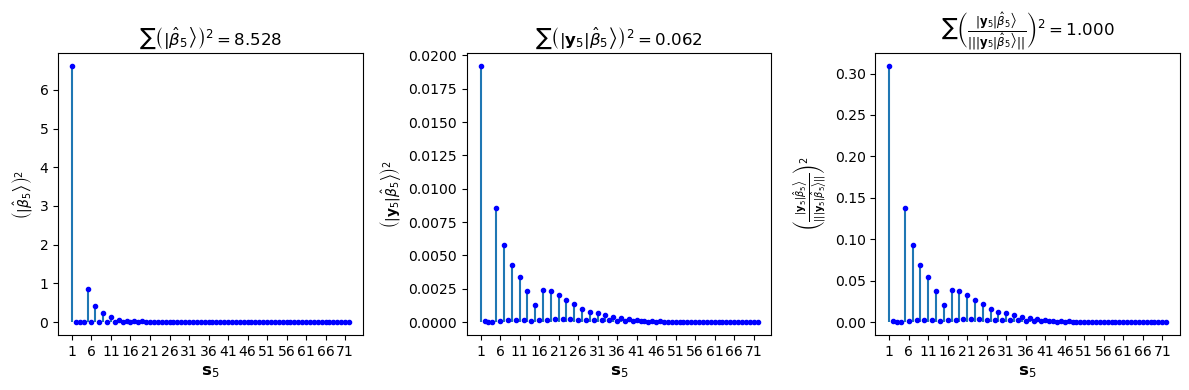

In [133]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, beta_hat_5_square, "b.")
ax.vlines(xarray, ymin=0, ymax=beta_hat_5_square)
ax.set_ylabel("\$\\left( \\left| \\hat{\\beta}_5 \\right> \\right)^2\$")
ax.set_xlabel("\$\\mathbf{s}_5\$", fontsize=12)
ax.set_xticks(xticks)
title = @sprintf "\$\\sum \\left( \\left| \\hat{\\beta}_5 \\right> \\right)^2 =%.3f \$" sum(beta_hat_5_square)
ax.set_title(title)

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, y_beta_hat_5_square, "b.")
ax.vlines(xarray, ymin=0, ymax=y_beta_hat_5_square)
ax.set_xlabel("\$\\mathbf{s}_5\$", fontsize=12)
ax.set_ylabel("\$\\left( \\left| \\mathbf{y}_5 |\\hat{\\beta}_5 \\right> \\right)^2\$")
ax.set_xticks(xticks)
title = @sprintf "\$ \\sum \\left( \\left| \\mathbf{y}_5 |\\hat{\\beta}_5 \\right> \\right)^2 =%.3f \$" sum(y_beta_hat_5_square)
ax.set_title(title)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, y_beta_hat_5_after_norm_square, "b.")
ax.vlines(xarray, ymin=0, ymax=y_beta_hat_5_after_norm_square)
ax.set_xlabel("\$\\mathbf{s}_5\$", fontsize=12)
ax.set_ylabel("\$\\left( \\frac{\\left| \\mathbf{y}_5 |\\hat{\\beta}_5 \\right>}{|| \\left|\\mathbf{y}_5 |\\hat{\\beta}_5 \\right> ||} \\right)^2\$")
ax.set_xticks(xticks)
title = @sprintf "\$ \\sum \\left( \\frac{\\left| \\mathbf{y}_5 |\\hat{\\beta}_5 \\right>}{|| \\left|\\mathbf{y}_5 |\\hat{\\beta}_5 \\right> ||} \\right)^2 =%.3f \$" sum(y_beta_hat_5_after_norm_square)
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/beta_s5_xi.pdf")
plt.show()

### Part 12-1: $\xi(\textbf{x}_{4}, \textbf{x}_{5})$

In [193]:
# First calculate xi-matrix 
p_x4_x5_given_Y = zeros(N,N)
for row_idx = 1:N
    p_x4_x5_given_Y[row_idx,:] = p_x4_x5_mat[row_idx, :] .* y_beta_hat_5_after_norm_x_square
end

# Start to calculate the normalization constant for matrix
p_x4_marginal_vec_given_Y = zeros(N,1)
for idx = 1:N
    p_x4_marginal_vec_given_Y[idx] = sum(w0 .* p_x4_x5_given_Y[idx,:]) # \int_x5 p(x4,x5) dx5 = p(x4)
end
mat_normalization_constant = sum(w0 .* p_x4_marginal_vec_given_Y)

# Normalize the matrix
p_x4_x5_given_Y_norm = p_x4_x5_given_Y ./ mat_normalization_constant;

In [194]:
# Check the sum of matrix is 1
p_x4_marginal_vec_given_Y_norm = zeros(N,1)
for idx = 1:N
    p_x4_marginal_vec_given_Y_norm[idx] = sum(w0 .* p_x4_x5_given_Y_norm[idx,:]) # \int_x5 p(x4,x5) dx5 = p(x4)
end
sum(w0 .* p_x4_marginal_vec_given_Y_norm)

1.0

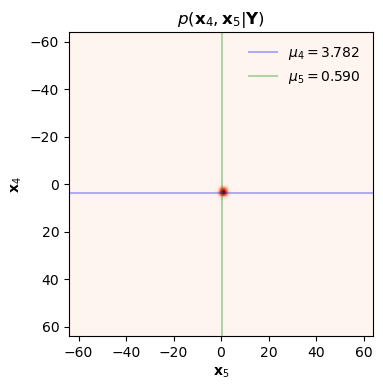

In [202]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

im = ax.imshow(p_x4_x5_given_Y_norm, cmap="Reds", extent=(-64,64,64,-64))
ax.set_xlabel("\$\\mathbf{x}_5\$")
ax.set_ylabel("\$\\mathbf{x}_4\$")
title = "\$p(\\mathbf{x}_4, \\mathbf{x}_5| \\mathbf{Y})\$"
ax.set_title(title)

label = @sprintf "\$ \\mu_{%d}=%.3f\$" 4 y_record[4]
ax.axhline(y_record[4], color="blue", label=label, alpha=0.3)


label = @sprintf "\$ \\mu_{%d}=%.3f\$" 5 y_record[5]
ax.axvline(y_record[5], color="green", label=label, alpha=0.3)

ax.legend(frameon=false)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/p_x4_x5_given_y1toy4.pdf")
plt.show()

In [196]:
p_x4_given_Y = zeros(N,1)
p_x5_given_Y = zeros(N,1)
for idx = 1:N
    p_x4_given_Y[idx] = sum(w0 .* p_x4_x5_given_Y_norm[idx,:]) # \int_x5 p(x4,x5) dx5 = p(x4)
    p_x5_given_Y[idx] = sum(w0 .* p_x4_x5_given_Y_norm[:, idx])
end
println(sum(w0 .* p_x4_given_Y))
println(sum(w0 .* p_x5_given_Y))

1.0
1.0


### Part 12-2: $\xi(\textbf{s}_{4}, \textbf{s}_{5})$

In [198]:
# First calculate xi-matrix 
p_s4_s5_given_Y = zeros(Nv,Nv)
for row_idx = 1:Nv
    p_s4_s5_given_Y[row_idx,:] = p_s4_s5_mat[row_idx, :] .* y_beta_hat_5_after_norm
end

# Start to calculate the normalization constant for matrix
p_s4_marginal_vec_given_Y = zeros(Nv,1)
for idx = 1:Nv
    p_s4_marginal_vec_given_Y[idx] = sum(p_s4_s5_given_Y[idx,:]) # \int_x5 p(x4,x5) dx5 = p(x4)
end
mat_normalization_constant = sum(p_s4_marginal_vec_given_Y)

# Normalize the matrix
p_s4_s5_given_Y_norm = p_s4_s5_given_Y ./ mat_normalization_constant;

In [200]:
# Check the sum of matrix is 1
sum(p_s4_s5_given_Y_norm)

0.9999999999999999

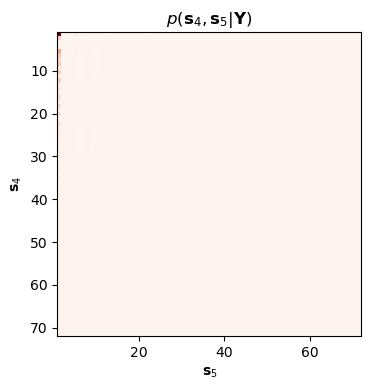

In [205]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

im = ax.imshow(p_s4_s5_given_Y_norm, cmap="Reds", extent=(1,Nv,Nv,1))
ax.set_xlabel("\$\\mathbf{s}_5\$")
ax.set_ylabel("\$\\mathbf{s}_4\$")
title = "\$p(\\mathbf{s}_4, \\mathbf{s}_5| \\mathbf{Y})\$"
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/p_x4_x5_given_y1toy4.pdf")
plt.show()